In [1]:
import librosa
from itertools import tee
from moviepy.editor import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [3]:
def generate_video(audio_path, vocal_path, video_path, image_filetype=".png", image_filename = "dim1-dim2-dim3", image_steps = 20, image_index_start = 1, transients_Only = True, frame_rate = 30, 
                   frame_smoothing=4, spike_factor = 2, bass_freq = 55, sinusoid_freq = 1, sinusoid_threshold = .1, local_max_threshold = .6, output_path="video.mp4"):
    print("--- loading audio ---")
    y, sr, l = load_audio(audio_path)
    y2, _, _ = load_audio(vocal_path)
    print("--- transforming audio ---")
    y_harm, y_perc = librosa.effects.hpss(y) # seperate transients 
    if transients_Only:
        y = y_perc 
        
    # The three data streams    
        
    bass = extract_frequency_band(y, sr, bass_freq) # bass intensity
    centroid = spectral_centroid(y_harm, sr, sinusoid_threshold) # spectral centroid 
    vocals = extract_waveform_loudness(y2) # vocal track loudness
    
    
    loudness_sr = l / len(vocals) # sample rate of vocal amplitude
    vocals = sinusoid(vocals, loudness_sr, sinusoid_freq, sinusoid_threshold) # convert to masked sinusoid
    _, beats = librosa.beat.beat_track(y=y, sr=sr, units="samples") # detect beat onset boundaries
    beats = np.array([beats[n] for n in range(0, (len(beats)), 4)]) # convert to 4/4 measures
    beats = beats * (len(bass) / len(y)) # convert boundary units from realtime samples to fft samples
    beats = [int(beat) for beat in beats] # map onto array indices
    
    # Generating the final transformed curves 
    
    bass_steps = audio_curve_to_frames(l, bass, frame_rate, frame_smoothing, spike_factor, image_steps, image_index_start, local_max = beats, local_max_threshold = local_max_threshold)
    centroid_steps = audio_curve_to_frames(l, centroid, frame_rate, frame_smoothing, .5, image_steps, image_index_start)
    vocal_steps = audio_curve_to_frames(l, vocals, frame_rate, frame_smoothing, 1, image_steps, image_index_start)
    print("--- plotting bass curve ---")
    plt.plot(bass_steps)
    plt.show()
    print("--- plotting spectral centroid curve ---")
    plt.plot(centroid_steps)
    plt.show()
    print("--- plotting vocal curve ---")
    plt.plot(vocal_steps)
    plt.show()
    print("--- loading image files ---")
    audio_curve_to_video_3d(video_path, bass_steps, centroid_steps, vocal_steps, image_filename, image_filetype, l, frame_rate, audio_path, output_path)

def load_audio(audio_path):
    y, sr = librosa.load(audio_path) # 1-d wave file with sample rate
    l = y.shape[0] / sr # calculate length of the audio clip
    return y, sr, l

def extract_waveform_loudness(y):
    """
    Computes the energy of a waveform for each time frame
    """
    S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
    return librosa.feature.rms(S=S)[0]

def sinusoid(y, sr, freq, threshold):
    """
    returns sinusoid over timeframe if amplitude is above threshold
    """
    sin_wave = (np.sin(2 * np.pi * freq * np.linspace(0, len(y) / sr, len(y))) + 1) /2
    x = y / max(y)
    return sin_wave * (x > threshold)

def spectral_centroid(y, sr, threshold):
    """
    Gives the spectral centroid for all sufficiently loud time frames
    """
    centroid = librosa.feature.spectral_centroid(y, sr)[0]
    loudness = extract_waveform_loudness(y)
    c_len = len(centroid)
    l_len = len(loudness)
    if c_len < l_len:
        scale = l_len / c_len
        loudness = np.array([loudness[int(i * scale)] for i in range(c_len)])
    elif l_len < c_len:
        scale = c_len / l_len
        centroid = np.array([centroid[int(i * scale)] for i in range(l_len)])
    loudness = loudness / max(loudness)
    mask = loudness > threshold
    return centroid * mask
    
def extract_frequency_band(y, sr, frequency = 55):
    """
    Takes in a waveform and isolates one frequency using fourier transform
    """
    D = librosa.stft(y) # perform DFT on the waveform
    DB = librosa.amplitude_to_db(np.abs(D), ref=np.max) # convert complex DFT to db scale
    bins = librosa.fft_frequencies(sr=sr) # recover frequency bins through DFT
    where = np.where(np.isclose(bins, frequency, atol=5)) # Find the bin that is closest to the desired frequency
    freq_band = DB[where[0], :] # isolate the frequency bin
    freq_normalized = ((freq_band + 80) / 80)[0] # quick hacked RMS to normalize amplitude from 0 to 1
    return freq_normalized

def audio_curve_to_frames(l, freq_normalized, frame_rate, frame_smoothing, spike_factor, image_steps, image_index_start, local_max = None, local_max_threshold = .6):
    """
    smoothes an audio curve and transforms it to a 1d array with a discrete intensity for each video frame.
    """
    time_step = (freq_normalized.shape[0] / l) / frame_rate # samples per frame
    kernel = smoother(int(frame_smoothing * time_step)) # create kernel for gaussian smoothing
    freq_normalized = np.convolve(freq_normalized, kernel, mode="same") # linear convolution
    freq_normalized = 1/(max(freq_normalized) - min(freq_normalized))*(freq_normalized - max(freq_normalized)) + 1 # normalize
    if spike_factor > 0:
        freq_normalized = np.exp(freq_normalized * spike_factor) # pull down low values and narrow spikes
        freq_normalized = 1/(max(freq_normalized) - min(freq_normalized))*(freq_normalized - max(freq_normalized)) + 1 # normalize again
    if spike_factor < 0:
        freq_normalized = np.log((freq_normalized + 1)) # logarithmize
        freq_normalized = 1/(1 + np.exp((-freq_normalized) - .5)) # sigmoidal
        freq_normalized = 1/(max(freq_normalized) - min(freq_normalized))*(freq_normalized - max(freq_normalized)) + 1 # normalize again
    if local_max is not None:
        local_max = np.concatenate([local_max, np.array([len(freq_normalized)- 1])])
        freq_normalized = maximize_local(freq_normalized, local_max, local_max_threshold)
    freq_steps = np.floor(freq_normalized * (image_steps - 1 - image_index_start)) + image_index_start + 1 # mapping frequencies to given integer range
    video_steps = [int(freq_steps[int(x * time_step)]) for x in range(int(l * frame_rate))]
    return video_steps

def maximize_local(curve, frames, threshold):
    """
    normalizes a series locally by dividing it into segments
    """
    constr = curve.copy()
    for l, r in pairwise(frames):
        c_slice = curve[l:r]
        min_val = min(c_slice)
        max_val = max(c_slice)
        ceiling = max_val
        if max_val > threshold:
            ceiling = 1
        c_slice = (ceiling)/(max_val-min_val)*(c_slice-max_val)+ceiling
        constr[l:r] = c_slice
    return constr

def audio_curve_to_video_3d(video_path, d1, d2, d3, image_filename, image_filetype, l, frame_rate, audio_path, output_path):
    """
    Generates video with underlying audio clip with frame lookup from 3 dimensions
    """
    
    images = [f"{video_path}{image_filename.replace('dim1', str(d1[i])).replace('dim2', str(d2[i])).replace('dim3', str(d3[i]))}{image_filetype}" for i in range(len(d1))] # mapping to file names
    video_clip = ImageSequenceClip(images, fps=frame_rate) # Building the stop-motion graphics
    audio_clip = AudioFileClip(audio_path) # Loading audio into moviepy
    video_clip = video_clip.set_audio(audio_clip) # overlaying audio
    video_clip.write_videofile(output_path) # write to disk

def smoother(size, sigma = None):
    """
    1d kernel convolution gauss filter
    """
    if sigma == None:
         sigma = size / 5
    lin = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(lin) / np.square(sigma))
    return gauss / np.sum(gauss)

## Some example generations

--- loading audio ---
--- transforming audio ---
--- plotting bass curve ---


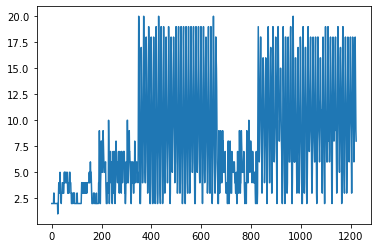

--- plotting treble curve ---


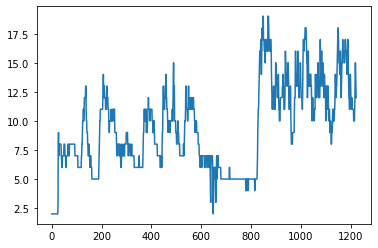

--- plotting vocal curve ---


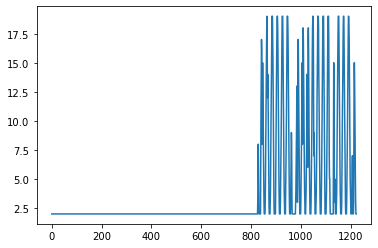

--- loading image files ---
Moviepy - Building video video-19-02-58.mp4.
MoviePy - Writing audio in video-19-02-58TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video-19-02-58.mp4



Moviepy - Done !
Moviepy - video ready video-19-02-58.mp4


In [4]:
generate_video(audio_path = "music_short2.wav", vocal_path = "music_short2_vocals.wav", video_path = "images/3dim/", image_filetype=".png", frame_rate = 20, output_path=f"video-{datetime.now().strftime('%H-%M-%S')}.mp4") 

--- loading audio ---
--- transforming audio ---
--- plotting bass curve ---


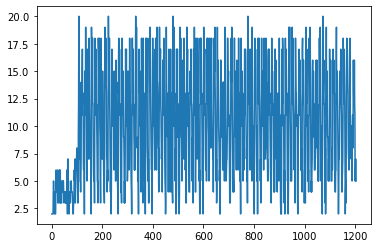

--- plotting treble curve ---


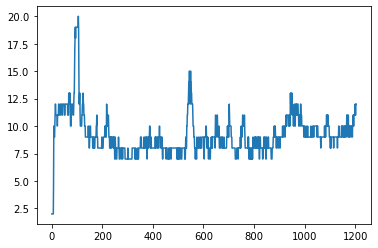

--- plotting vocal curve ---


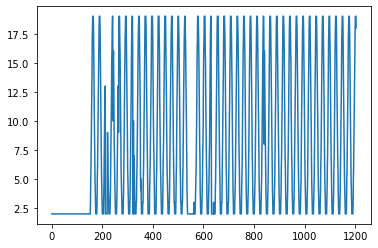

--- loading image files ---
Moviepy - Building video video-19-03-29.mp4.
MoviePy - Writing audio in video-19-03-29TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video-19-03-29.mp4



Moviepy - Done !
Moviepy - video ready video-19-03-29.mp4


In [5]:
generate_video(audio_path = "music_short.wav", vocal_path = "music_short_vocals.wav", video_path = "images/3dim/", image_filetype=".png", frame_rate = 20, frame_smoothing = 2, output_path=f"video-{datetime.now().strftime('%H-%M-%S')}.mp4") 

--- loading audio ---
--- transforming audio ---
--- plotting bass curve ---


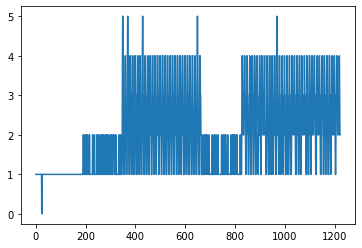

--- plotting treble curve ---


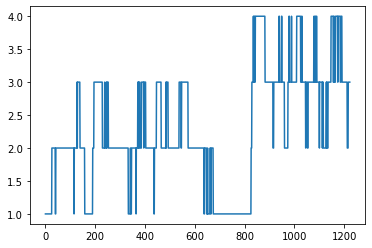

--- plotting vocal curve ---


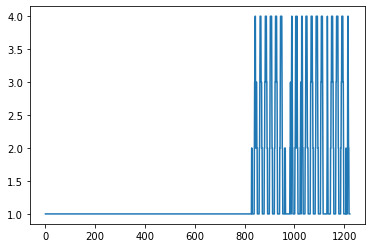

--- loading image files ---
Moviepy - Building video video-19-03-59.mp4.
MoviePy - Writing audio in video-19-03-59TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video-19-03-59.mp4



Moviepy - Done !
Moviepy - video ready video-19-03-59.mp4


In [6]:
generate_video(audio_path = "music_short2.wav", vocal_path = "music_short2_vocals.wav", video_path = "grid_images/grid_", image_filetype=".png", image_filename="dim1dim2dim3", frame_rate = 20, image_steps = 5, image_index_start = 0, output_path=f"video-{datetime.now().strftime('%H-%M-%S')}.mp4") 

## Random testing and experimenting

In [7]:
y, sr = librosa.load("music_short2.wav")

In [8]:
len(y)

1348952

In [9]:
len(extract_waveform_loudness(y))

2631

In [10]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
y_harmonic, y_percussive = librosa.effects.hpss(y)
D = librosa.stft(y_percussive)

In [12]:
y_percussive.shape

(1348952,)